# Model Comparison Report

This notebook compares the performance of the original MLP model with several other machine learning models and a non-ML baseline using the DASS dataset.

### A Note on BERT and PHQ-9

The original request mentioned two additional comparison points:
1.  **Fine-tuned BERT**: BERT is a powerful model for natural language processing. However, the DASS dataset used in this project consists of numerical and categorical responses, not free-form text. Therefore, a BERT-based model is not applicable to this specific dataset.
2.  **Baseline PHQ-9 Scoring**: The PHQ-9 is another common questionnaire for depression screening. The current dataset is based on the DASS (Depression, Anxiety, and Stress Scales). As such, this report uses the official DASS scoring rules for the depression subscale as the non-ML baseline, which is the appropriate baseline for this dataset.

## 1. Setup and Data Loading

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the preprocessed data
df = pd.read_csv("final_data.csv")
df.head()

,Unnamed: 0,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,...,education,urban,gender,religion,race,married,familysize,age_group,total_count,target
0,0,4,4,2,4,4,4,4,4,2,...,2,3,2,12,1.0,1,2,2,216.0,Extremely Severe
1,1,4,1,2,3,4,4,3,4,3,...,2,3,2,7,7.0,1,4,2,189.0,Severe
2,2,3,1,4,1,4,3,1,3,2,...,2,3,2,4,6.0,1,3,3,171.0,Moderate
3,3,2,3,2,1,3,3,4,2,3,...,1,3,2,4,7.0,1,5,2,153.0,Mild
4,4,2,2,3,4,4,2,4,4,4,...,3,2,2,10,1.0,1,4,3,212.0,Severe


## 2. DASS Baseline Implementation

The DASS questionnaire is composed of three subscales: Depression, Anxiety, and Stress. A standard non-ML baseline can be established by using the official DASS scoring for the Depression subscale.

The Depression scale consists of items: 3, 5, 10, 13, 16, 17, 21, 24, 26, 31, 34, 37, 38, 42.

The severity levels are:
- Normal: 0-9
- Mild: 10-13
- Moderate: 14-20
- Severe: 21-27
- Extremely Severe: 28+

In [2]:
# Define the DASS Depression items
depression_items = [f'Q{i}A' for i in [3, 5, 10, 13, 16, 17, 21, 24, 26, 31, 34, 37, 38, 42]]

# The original data was 1-4, but DASS scores are 0-3. Subtract 1 from each response.
df_dass = df.copy()
for item in depression_items:
    if item in df_dass.columns:
        df_dass[item] = df_dass[item] - 1

# Calculate the DASS Depression score
df_dass['dass_depression_score'] = df_dass[depression_items].sum(axis=1)

# Define the severity levels
def get_dass_severity(score):
    if score <= 9:
        return 'Normal'
    elif score <= 13:
        return 'Mild'
    elif score <= 20:
        return 'Moderate'
    elif score <= 27:
        return 'Severe'
    else:
        return 'Extremely Severe'

df_dass['dass_severity'] = df_dass['dass_depression_score'].apply(get_dass_severity)

## 3. Model Training and Evaluation

In [3]:
# Prepare the data for the ML models
X = df.drop(['target', 'total_count', 'Unnamed: 0'], axis=1, errors='ignore')
y = df['target']

# Ensure the order of severity levels is consistent for reports
labels = ['Normal', 'Mild', 'Moderate', 'Severe', 'Extremely Severe']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3.1 DASS Official Scoring (Baseline)

--- DASS Official Scoring (Baseline) ---
Accuracy: 0.4398
                  precision    recall  f1-score   support

          Normal       0.82      0.72      0.76      2025
            Mild       0.40      0.25      0.31      1259
        Moderate       0.47      0.29      0.36      2242
          Severe       0.28      0.21      0.24      1689
Extremely Severe       0.26      0.98      0.42       732

        accuracy                           0.44      7947
       macro avg       0.45      0.49      0.42      7947
    weighted avg       0.49      0.44      0.43      7947



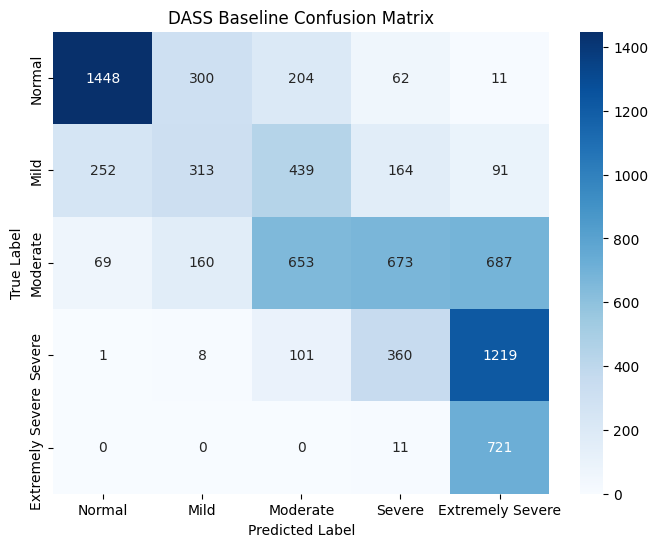

In [4]:
y_true_baseline = y_test
y_pred_baseline = df_dass.loc[y_test.index]['dass_severity']

print("--- DASS Official Scoring (Baseline) ---")
print(f"Accuracy: {accuracy_score(y_true_baseline, y_pred_baseline):.4f}")
print(classification_report(y_true_baseline, y_pred_baseline, labels=labels, zero_division=0))

conf_matrix_baseline = confusion_matrix(y_true_baseline, y_pred_baseline, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('DASS Baseline Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### 3.2 Machine Learning Models

--- Logistic Regression ---
Accuracy: 0.9980
                  precision    recall  f1-score   support

          Normal       1.00      1.00      1.00      2025
            Mild       1.00      1.00      1.00      1259
        Moderate       1.00      1.00      1.00      2242
          Severe       1.00      1.00      1.00      1689
Extremely Severe       0.99      0.99      0.99       732

        accuracy                           1.00      7947
       macro avg       1.00      1.00      1.00      7947
    weighted avg       1.00      1.00      1.00      7947



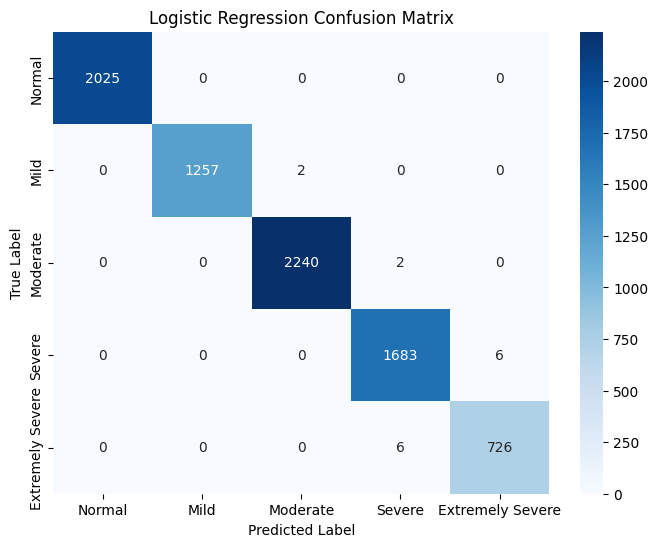

--- SVM ---
Accuracy: 0.9761
                  precision    recall  f1-score   support

          Normal       0.99      0.99      0.99      2025
            Mild       0.96      0.96      0.96      1259
        Moderate       0.97      0.98      0.98      2242
          Severe       0.98      0.97      0.98      1689
Extremely Severe       0.98      0.97      0.97       732

        accuracy                           0.98      7947
       macro avg       0.97      0.97      0.97      7947
    weighted avg       0.98      0.98      0.98      7947



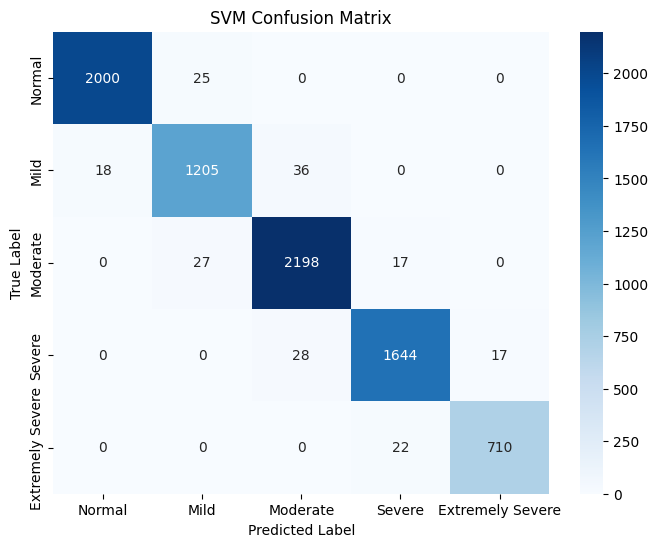

--- Random Forest ---
Accuracy: 0.8017
                  precision    recall  f1-score   support

          Normal       0.89      0.91      0.90      2025
            Mild       0.67      0.55      0.60      1259
        Moderate       0.76      0.84      0.80      2242
          Severe       0.79      0.82      0.81      1689
Extremely Severe       0.93      0.76      0.83       732

        accuracy                           0.80      7947
       macro avg       0.81      0.78      0.79      7947
    weighted avg       0.80      0.80      0.80      7947



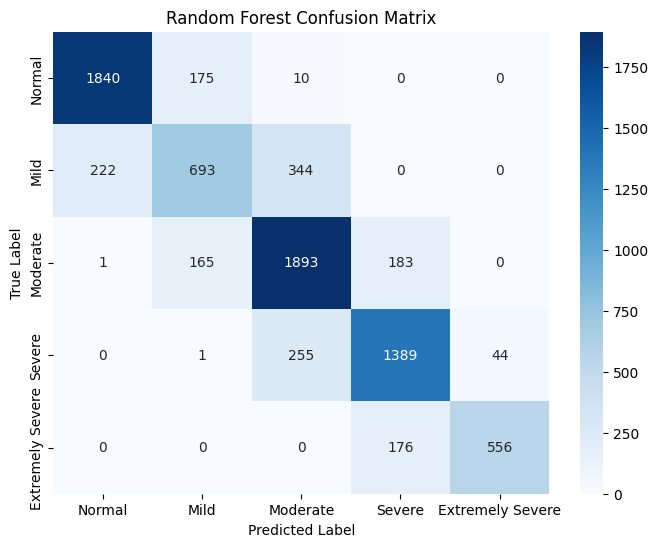

--- MLP ---
Accuracy: 0.9981
                  precision    recall  f1-score   support

          Normal       1.00      1.00      1.00      2025
            Mild       1.00      1.00      1.00      1259
        Moderate       1.00      1.00      1.00      2242
          Severe       1.00      1.00      1.00      1689
Extremely Severe       0.99      1.00      0.99       732

        accuracy                           1.00      7947
       macro avg       1.00      1.00      1.00      7947
    weighted avg       1.00      1.00      1.00      7947



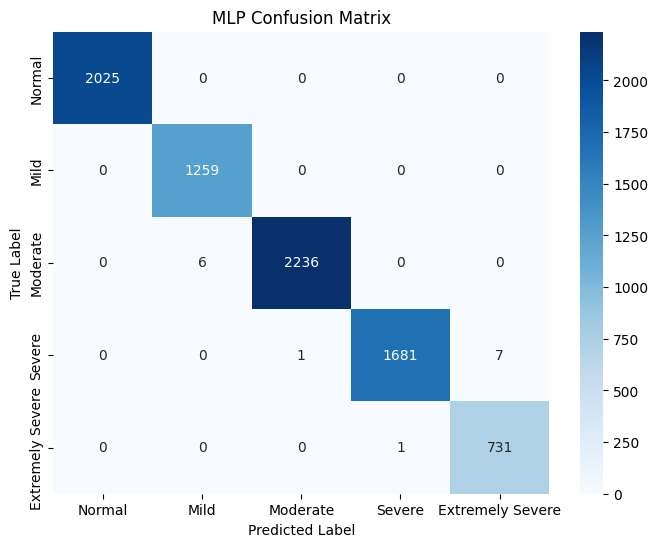

In [5]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(10,20,30,20,10), max_iter=1000, random_state=42)
}

for name, model in models.items():
    print(f"--- {name} ---")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, labels=labels, zero_division=0))
    
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()